## Try out pandas subsampling and Doodson filter

Doodson filter requires hourly data for best results but NEPTUNE's POD2 75KHz ADCP has data points every 2 seconds. So I will subsample (using a mean) to hourly output and then use Ben's doodslon filter from Salish Sea tools / tidetools.

### NEPTUNE - ADCP metadata

**Data points every 2 SECONDS **

platform_depth = 395. ;
site_name = "UpperSlope_IP_2012-06" ;
device_name = "RDI Workhorse Long Ranger ADCP 75 kHz (9202)" ;
		
**dimensions**:
	time = 33654 ;
	depth = 50 ;
	latitude = 1 ;
	longitude = 1 ;

**variables**:
	
	double time(time) ;
		time:standard_name = "time" ;
		time:long_name = "time" ;
		time:units = "days since 19700101T000000Z" ;
		time:axis = "T" ;
		time:calendar = "gregorian" ;
	float depth(depth) ;
		depth:standard_name = "depth" ;
		depth:long_name = "approx. water depth of measurement bin" ;
		depth:units = "meters" ;
		depth:axis = "Z" ;
		depth:positive = "down" ;
	float latitude(latitude) ;
		latitude:standard_name = "latitude" ;
		latitude:long_name = "latitude" ;
		latitude:units = "degrees_north" ;
		latitude:axis = "Y" ;
	float longitude(longitude) ;
		longitude:standard_name = "longitude" ;
		longitude:long_name = "longitude" ;
		longitude:units = "degrees_east" ;
		longitude:axis = "X" ;
	float u(time, depth) ;
		u:standard_name = "eastward_sea_water_velocity" ;
		u:long_name = "eastward sea water velocity" ;
		u:units = "meters/second" ;
		u:_FillValue = -9999999.f ;
	float v(time, depth) ;
		v:standard_name = "northward_sea_water_velocity" ;
		v:long_name = "northward sea water velocity" ;
		v:units = "meters/second" ;
		v:_FillValue = -9999999.f ;
	float w(time, depth) ;
		w:standard_name = "upward_sea_water_velocity" ;
		w:long_name = "upward sea water velocity" ;
		w:units = "meters/second" ;
		w:_FillValue = -9999999.f ;
	float temp(time) ;
		temp:standard_name = "sea_water_temperature" ;
		temp:long_name = "sea water temperature" ;
		temp:units = "K" ;
		temp:_FillValue = -9999999.f ;

In [2]:
import datetime as dtm      # Python's standard date and time library
import dateutil as dutil    # Powerful datetime extensions
import glob
from math import *
from matplotlib.dates import num2date
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import pytz                 # Timezone extensions
import seaborn as sns
import scipy.io


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def get_dataframe(file,u_key='u',v_key='v',w_key='w',time_key='time',temp_key='temp',depth_index=26):
    '''
    INPUT:
    file: filename string
    u_key: key string for eastward velocity, default is 'u'
    v_key: key string for northward velocity, default is 'v'
    w_key: key string for vertical velocity, default is 'w'
    time_key: key string for time, default is 'time'
    temp_key: key string for temperature, default is 'temp'
    depth_index: integer defining depth slice. Default is 26, depth[26]=170.6 m.
    
    OUTPUT:
    df: dataframe with columns time,u,v,w,temp
    '''
    data = Dataset(file)
    time = data.variables['time']
    time_py = ONC_to_pytime(time)
    uu = data.variables['u']
    vv = data.variables['v']
    ww = data.variables['w']
    temp = data.variables['temp']
    
    dd = {'time': time_py, 'u': uu[:,depth_index], 'v': vv[:,depth_index], 'w': ww[:,depth_index], 'temp': temp[:]}
    df = pd.DataFrame(data=dd)
    return(df)
  

def append_dataframe(df, df2):
    '''INPUT
    df: dataframe to append to.
    df2: dataframe to be appended.
    
    OUTPUT:
    Appended dataframes
    '''
    return(df.append(df2, ignore_index=True))
    
def ONC_to_pytime(time):
    '''
    Transform dates into something python can use.
    Returns python datetimes array from time.
    '''
    date1 = dtm.date(1, 1, 1)
    date2 = dtm.date(1970,1,1)
    timedelta1 = date2 - date1
    python_datetimes = np.array([(dtm.datetime.fromordinal(int(tt)) 
                                  + dtm.timedelta(days=tt%1)
                                  + timedelta1 
                                  + dtm.timedelta(days=1)) for tt in time])
    return(python_datetimes)


    


In [4]:
# INPUT 
file = ('ADCP75kHzPOD2/2014/BarkleyCanyon_UpperSlope_ADCP75kHz_20140501T000001Z_20140501T235959Z-binMapLinearInterp.nc')
data1 = Dataset(file)
site_name = 'UpperSlope_IP_2012-06'
lon = data1.variables['longitude']
lat = data1.variables['latitude']
depth = data1.variables['depth']


In [5]:
# Read in pandas data frames
data_170m = pd.read_csv('BarkleyUpperSlope_75kHzADCP_summer2014_170m.csv')
data_106m = pd.read_csv('BarkleyUpperSlope_75kHzADCP_summer2014_106m.csv')

In [6]:
# Convert to python time
python_time = ONC_to_pytime(data_170m.time)

In [49]:
# Build time series (Maybe this is redundant...)
u_ser_106m = pd.Series(np.array(data_106m.u), index=python_time)
v_ser_106m = pd.Series(np.array(data_106m.v), index=python_time)
w_ser_106m = pd.Series(np.array(data_106m.w), index=python_time)

u_sub_106m = u_ser_106m.resample('1H').mean()
v_sub_106m = v_ser_106m.resample('1H').mean()
w_sub_106m = w_ser_106m.resample('1H').mean()

print(v_sub_106m.head(10))

2014-05-01 00:00:00    0.002824
2014-05-01 01:00:00   -0.074457
2014-05-01 02:00:00   -0.148411
2014-05-01 03:00:00   -0.152529
2014-05-01 04:00:00   -0.118192
2014-05-01 05:00:00   -0.106704
2014-05-01 06:00:00   -0.067554
2014-05-01 07:00:00   -0.006487
2014-05-01 08:00:00    0.048570
2014-05-01 09:00:00    0.054640
Freq: H, dtype: float64


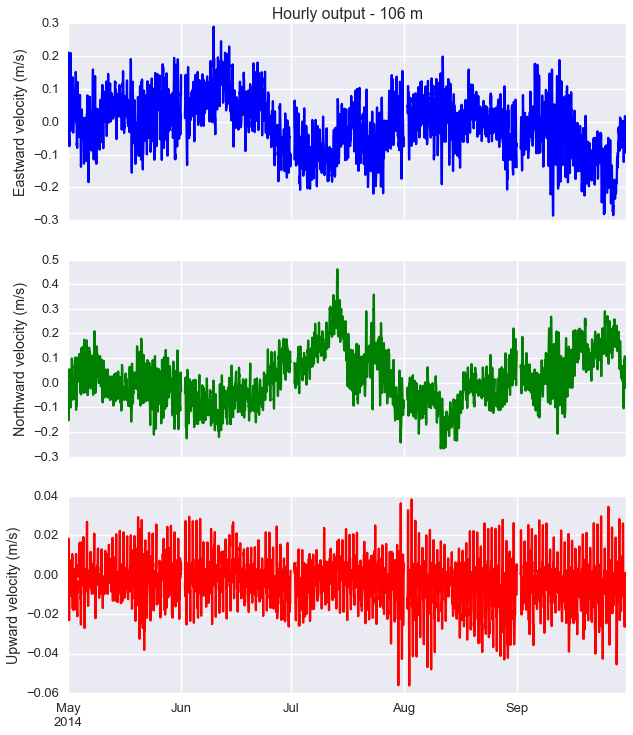

In [50]:
sns.set_context('talk')
sns.set_style('darkgrid')

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

u_sub_106m.plot(ax=ax[0],color='b')
v_sub_106m.plot(ax=ax[1],color='g')
w_sub_106m.plot(ax=ax[2],color='r')

ax[0].set_title('Hourly output - 106 m')
ax[0].set_ylabel('Eastward velocity (m/s)')
ax[1].set_ylabel('Northward velocity (m/s)')
ax[2].set_ylabel('Upward velocity (m/s)')


In [51]:
# Build time series (Maybe this is redundant...)
u_ser_170m = pd.Series(np.array(data_170m.u), index=python_time)
v_ser_170m = pd.Series(np.array(data_170m.v), index=python_time)
w_ser_170m = pd.Series(np.array(data_170m.w), index=python_time)

u_sub_170m = u_ser_170m.resample('1H').mean()
v_sub_170m = v_ser_170m.resample('1H').mean()
w_sub_170m = w_ser_170m.resample('1H').mean()


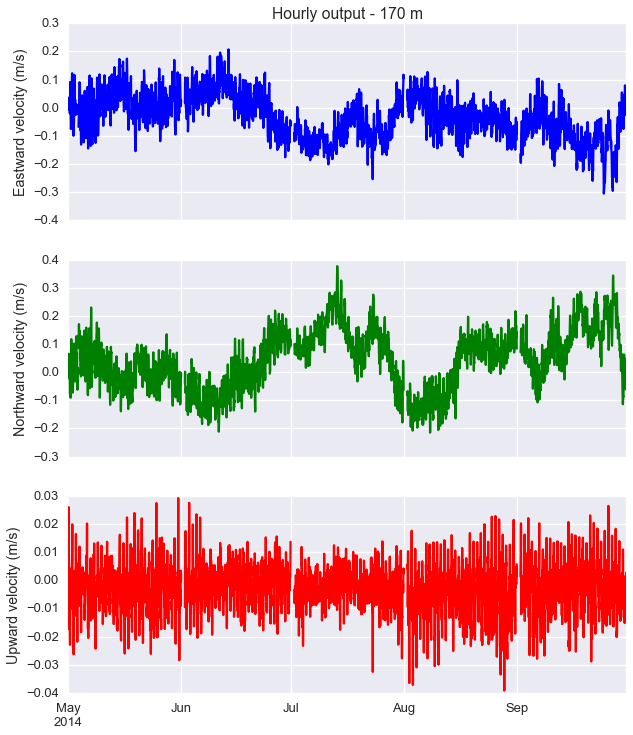

In [54]:
sns.set_context('talk')
sns.set_style('darkgrid')

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

u_sub_170m.plot(ax=ax[0],color='b')
v_sub_170m.plot(ax=ax[1],color='g')
w_sub_170m.plot(ax=ax[2],color='r')

ax[0].set_title('Hourly output - 170 m')
ax[0].set_ylabel('Eastward velocity (m/s)')
ax[1].set_ylabel('Northward velocity (m/s)')
ax[2].set_ylabel('Upward velocity (m/s)')


In [55]:
from salishsea_tools.tidetools import filter_timeseries

In [34]:
def filter_timeseries_modified(record, winlen=39, method='box'):
    """Filter a timeseries.
    
    Developed for wind and tidal filtering, but can be modified for use
    with a variety of timeseries data. The data record should be at least
    half a window length longer at either end than the period of interest
    to accommodate window length shrinking near the array edges.

    *This function can only operate along the 0 axis. Please modify to include
    an axis argument in the future.*
    
    Types of filters (*please add to these*):
    * **box**: simple running mean
    * **doodson**: Doodson bandpass filter (39 winlen required)
    
    :arg record: timeseries record to be filtered
    :type record: :py:class:`numpy.ndarray`, :py:class:`xarray.DataArray`,
                  or :py:class:`netCDF4.Variable`
    
    :arg winlen: window length
    :type winlen: integer
    
    :arg method: type of filter (ex. 'box', 'doodson', etc.)
    :type method: string
    
    :returns filtered: filtered timeseries
    :rtype: same as record
    """
    
    # Preallocate filtered record
    filtered = record.copy()
    
    # Length along time axis
    record_length = record.shape[0]

    # Window length
    w = (winlen - 1) // 2
    
    # Construct weight vector
    weight = np.zeros(w, dtype=int)
    
    # Select filter method
    if method is 'doodson':
        # Doodson bandpass filter (winlen must be 39)
        weight[[1, 2, 5, 6, 10, 11, 13, 16, 18]] = 1
        weight[[0, 3, 8]] = 2
        centerval = 0
    elif method is 'box':
        # Box filter
        weight[:] = 1
        centerval = 1
    else:
        raise ValueError('Invalid filter method: {}'.format(method))
    
    # Loop through record
    for i in range(record_length):
        
        # Adjust window length for end cases
        W = min(i, w, record_length-i-1)
        Weight = weight[:W]
        Weight = np.append(Weight[::-1], np.append(centerval, Weight))
        Weight = (Weight/sum(Weight, centerval))
        
        # Expand weight dims so it can operate on record window
        for dim in range(record.ndim - 1):
            Weight = Weight[:, np.newaxis]
        
        # Apply mean over window length
        filtered[i] = np.sum(record[i-W:i+W+1] * Weight, axis=0)
    
    return filtered

In [56]:
u_sub_106m_filt = filter_timeseries_modified(u_sub_106m, winlen=39, method='doodson')
v_sub_106m_filt = filter_timeseries_modified(v_sub_106m, winlen=39, method='doodson')
w_sub_106m_filt = filter_timeseries_modified(w_sub_106m, winlen=39, method='doodson')

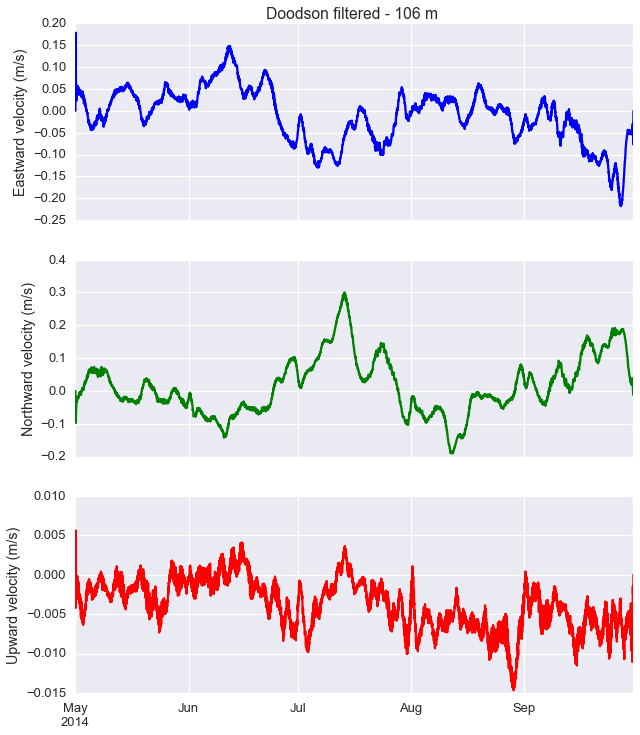

In [57]:
sns.set_context('talk')
sns.set_style('darkgrid')

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

u_sub_106m_filt.plot(ax=ax[0],color='b')
v_sub_106m_filt.plot(ax=ax[1],color='g')
w_sub_106m_filt.plot(ax=ax[2],color='r')

ax[0].set_title('Doodson filtered - 106 m ')
ax[0].set_ylabel('Eastward velocity (m/s)')
ax[1].set_ylabel('Northward velocity (m/s)')
ax[2].set_ylabel('Upward velocity (m/s)')


In [58]:
u_sub_170m_filt = filter_timeseries_modified(u_sub_170m, winlen=39, method='doodson')
v_sub_170m_filt = filter_timeseries_modified(v_sub_170m, winlen=39, method='doodson')
w_sub_170m_filt = filter_timeseries_modified(w_sub_170m, winlen=39, method='doodson')

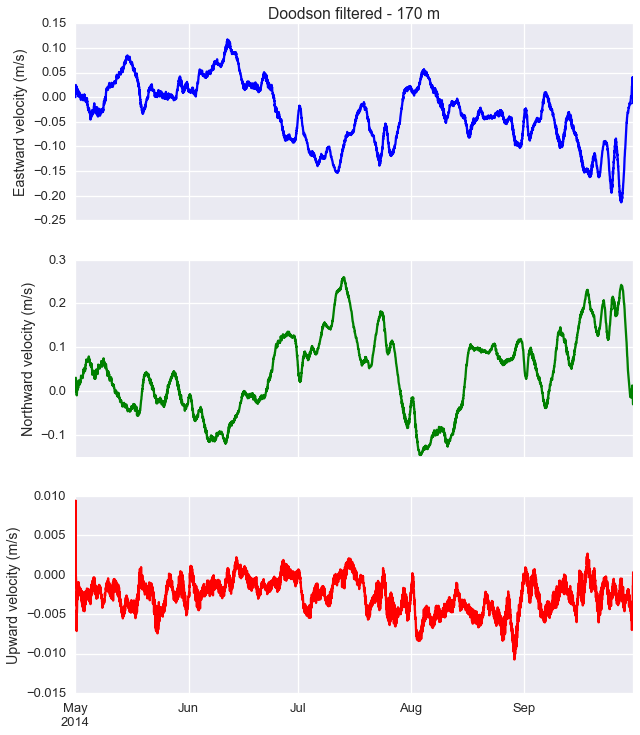

In [60]:
sns.set_context('talk')
sns.set_style('darkgrid')

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

u_sub_170m_filt.plot(ax=ax[0],color='b')
v_sub_170m_filt.plot(ax=ax[1],color='g')
w_sub_170m_filt.plot(ax=ax[2],color='r')

ax[0].set_title('Doodson filtered - 170 m')
ax[0].set_ylabel('Eastward velocity (m/s)')
ax[1].set_ylabel('Northward velocity (m/s)')
ax[2].set_ylabel('Upward velocity (m/s)')


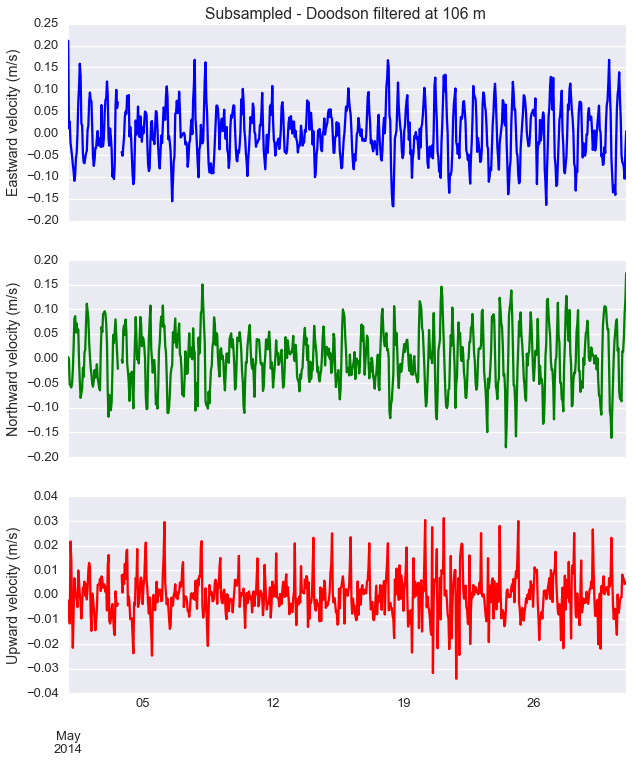

In [61]:
sns.set_context('talk')
sns.set_style('darkgrid')

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

(u_sub_106m[:24*30]-u_sub_106m_filt[:24*30]).plot(ax=ax[0],color='b')
(v_sub_106m[:24*30]-v_sub_106m_filt[:24*30]).plot(ax=ax[1],color='g')
(w_sub_106m[:24*30]-w_sub_106m_filt[:24*30]).plot(ax=ax[2],color='r')

ax[0].set_title('Subsampled - Doodson filtered at 106 m ')
ax[0].set_ylabel('Eastward velocity (m/s)')
ax[1].set_ylabel('Northward velocity (m/s)')
ax[2].set_ylabel('Upward velocity (m/s)')


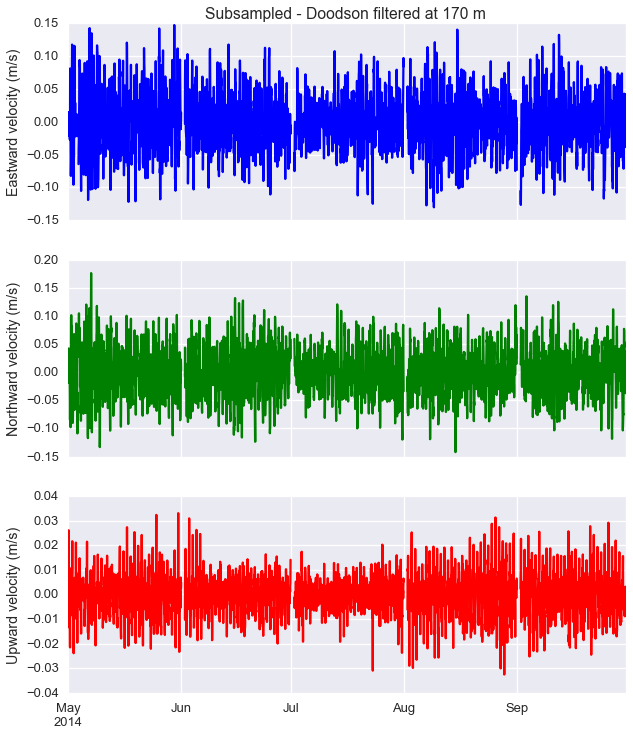

In [63]:
sns.set_context('talk')
sns.set_style('darkgrid')

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

(u_sub_170m-u_sub_170m_filt).plot(ax=ax[0],color='b')
(v_sub_170m-v_sub_170m_filt).plot(ax=ax[1],color='g')
(w_sub_170m-w_sub_170m_filt).plot(ax=ax[2],color='r')

ax[0].set_title('Subsampled - Doodson filtered at 170 m ')
ax[0].set_ylabel('Eastward velocity (m/s)')
ax[1].set_ylabel('Northward velocity (m/s)')
ax[2].set_ylabel('Upward velocity (m/s)')
